In [2]:
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 3. Flux Variance
For flux variance we will need the mean sonic temperature and the standard deviation of the sonic temperature. Again we open the csv files, and calculated what we need:

In [7]:
#Get the path of all files:
files = glob('ec_data\\*.csv')

std_Ts  = np.zeros(len(files))
mean_Ts = np.zeros(len(files))

dtime_array = np.empty(len(files), dtype=object)

for ii in range(0,len(files)):
    #Read out each csv
    df = pd.read_csv(files[ii], header=0)
    
    #Calculate temperature standard deviation
    std_Ts[ii]  = np.std(df.Ts)
    mean_Ts[ii] = np.mean(df.Ts) + 273.15
    
    #Get the time from the filename
    file_time       = files[ii].split('_')[-1]
    dtime_array[ii] = datetime.strptime(file_time, '%Y%m%d%H%M.csv')

Now we can calculate the flux-variance sensible heat

Text(0,0.5,'H (W/m$^2$)')

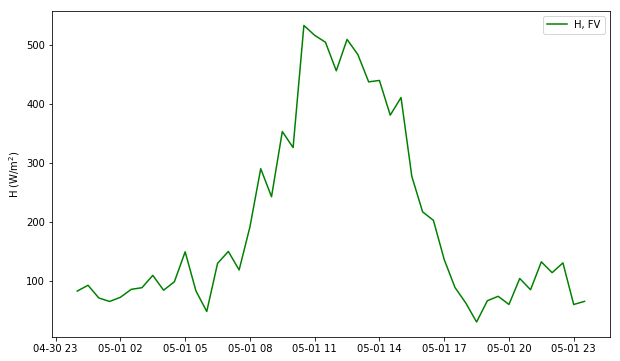

In [8]:
c_p   = 1003 #J/kg/K
rho_a = 1.25 #kg/m3
C_1   = 0.95 #[-]
kappa = 0.4  #[-]
g     = 9.81 #m/s2

#Site parameters
z = 46 #m
d = 22 #m

H_FV = rho_a*c_p*(std_Ts/C_1)**(3/2)*(kappa*g*(z-d)/mean_Ts)**(1/2)

plt.figure(figsize=(10,6))
#plt.plot(dtime_array, H, 'r', label='H, EC')
plt.plot(dtime_array, H_FV, 'g', label='H, FV')
plt.legend(loc='best')
plt.ylabel('H (W/m$^2$)')

However, we have to check for the validity of flux variance, as it is only valid if: -2 < z/L < -0.04
First we need to calculate the covariances between the horizontal wind components (u, v) and w:

In [11]:
cov_uw  = np.zeros(len(files))
cov_vw  = np.zeros(len(files))
cov_wTs = np.zeros(len(files))

for ii in range(0,len(files)):
    #Read out each csv
    df = pd.read_csv(files[ii], header=0)
    
    #Calculate covariances
    cov_uw[ii]  = np.cov(df.ux, df.uz)[0][1]
    cov_vw[ii]  = np.cov(df.uy, df.uz)[0][1]
    cov_wTs[ii] = np.cov(df.uz, df.Ts)[0][1]

Now we can calculate z/L, and test if flux-variance is valid...

Text(0,0.5,'z/L')

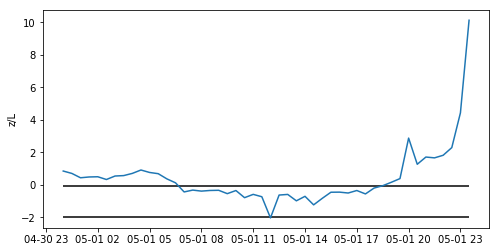

In [12]:
u_star = (cov_uw**2 + cov_vw**2)**(1/4)
L      = -u_star**3/ (kappa*g/mean_Ts*cov_wTs)

fv_valid = np.logical_and(np.greater(z/L, -2), np.greater(-0.04, z/L))

plt.figure(figsize=(8,4))
plt.plot(dtime_array, z/L)
plt.hlines((-0.04,-2), dtime_array[0], dtime_array[-1])
plt.ylabel('z/L')

..and filter out where MOST is not valid:

Text(0,0.5,'H (W/m$^2$)')

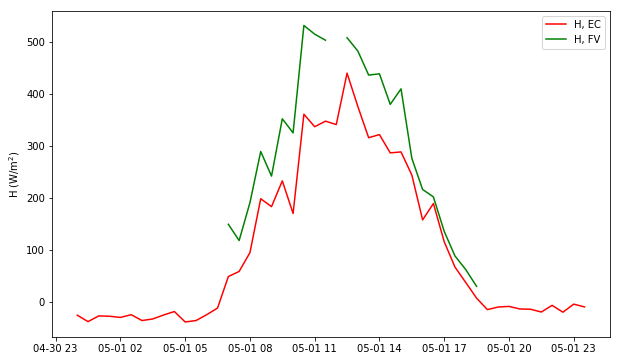

In [16]:
H_FV[~fv_valid] = np.nan

plt.figure(figsize=(10,6))
plt.plot(dtime_array, cov_wTs*rho_a*c_p, 'r', label='H, EC')
plt.plot(dtime_array, H_FV, 'g', label='H, FV')
plt.legend(loc='best')
plt.ylabel('H (W/m$^2$)')